
# PyTorch Lightning GAN






## Cài đặt package
Cần cài đặt packet pytorch-lightning.

In [1]:
# ! pip install --quiet "pytorch-lightning>=1.3" "torch>=1.6, <1.9" "torchvision" 

## Import thư viện

In [2]:
import os
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt



### Input

In [3]:
# Root directory for dataset
dataroot = "/data"

# Number of GPUs available.
AVAIL_GPUS = min(1, torch.cuda.device_count())

# Batch size during training
batch_size =  64

# Number of workers for dataloader
workers = os.cpu_count()

# Number of channels in the training images.
nc = 1
#  
image_size = 28


### MNIST DataModule

Below, we define a DataModule for the MNIST Dataset. To learn more about DataModules, check out our tutorial
on them or see the [latest docs](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html).

In [4]:
class DataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = dataroot,
        batch_size: int = batch_size,
        num_workers: int = workers,
        
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.ToTensor()        

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (nc, image_size, image_size)

    def prepare_data(self):
        
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

### A. Generator

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

### B. Discriminator

In [6]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

### C. GAN

#### A couple of cool features to check out in this example...

  - We use `some_tensor.type_as(another_tensor)` to make sure we initialize new tensors on the right device (i.e. GPU, CPU).
    - Lightning will put your dataloader data on the right device automatically
    - In this example, we pull from latent dim on the fly, so we need to dynamically add tensors to the right device.
    - `type_as` is the way we recommend to do this.
  - This example shows how to use multiple dataloaders in your `LightningModule`.

In [7]:
samples = []
losses = []
class GAN(LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        z_size: int = 100,
        lr: float = 0.0002,
        batch_size: int = batch_size,
        g_hidden_size: int = 32,
        d_hidden_size: int = 32,
        d_output_size:int = 1,
        **kwargs
        
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (channels, width, height)
        self.G = Generator(self.hparams.z_size, g_hidden_size, width*height)
        self.D = Discriminator(width*height, d_hidden_size, d_output_size)
        
        sample_size=16
        self.fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
        self.fixed_z = torch.from_numpy(self.fixed_z).float()
        
        self.automatic_optimization = False
    def sample_G(self,batch_size, z_size):
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        return self.G(z)
    def training_step(self, batch, batch_idx, optimizer_idx):
          
        z_size = self.hparams.z_size
        g_opt, d_opt = self.optimizers()
        
        real_images, _ = batch
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1
        
        fake_images = self.sample_G(batch_size, z_size)
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        # 1. Train with real images
        
        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = self.D(real_images)
        d_real_loss = self.real_loss(D_real)
        # 2. Train with fake images

        # Generate fake images
        # gradients don't have to flow during this step
        batch_size = real_images.size(0)
        D_fake = self.D(fake_images.detach())
        d_fake_loss = self.fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        
        D_fake = self.D(fake_images)
        g_loss = self.real_loss(D_fake) # use real loss to flip labels
        
        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()
        
        self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True)
        self.a, self.b = g_loss, d_loss
        
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        g_opt = torch.optim.Adam(self.G.parameters(), lr=lr)
        d_opt = torch.optim.Adam(self.D.parameters(), lr=lr)
        return g_opt, d_opt
    
    def real_loss(self,D_out, smooth=False):
        batch_size = D_out.size(0)
        # label smoothing
        if smooth:
            # smooth, real labels = 0.9
            labels = torch.ones(batch_size)*0.9
        else:
            labels = torch.ones(batch_size) # real labels = 1

        # numerically stable loss
        criterion = nn.BCEWithLogitsLoss()
        # calculate loss
        loss = criterion(D_out.squeeze(), labels)
        return loss
    def fake_loss(self,D_out):
        batch_size = D_out.size(0)
        labels = torch.zeros(batch_size) # fake labels = 0
        criterion = nn.BCEWithLogitsLoss()
        # calculate loss
        loss = criterion(D_out.squeeze(), labels)
        return loss
    def on_epoch_end(self):
        losses.append((self.b.item(), self.a.item()))
        # generate and save sample, fake images
        self.G.eval() # eval mode for generating samples
        samples_z = self.G(self.fixed_z)
        samples.append(samples_z)
        

In [8]:
dm = DataModule()
model = GAN(*dm.size())
trainer = Trainer(gpus=AVAIL_GPUS, max_epochs=500, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/batch/training_batch_loop.py:656: LightningDeprecationWarning: `training_step` hook signature has changed in v1.3. `optimizer_idx` argument has been removed in case of manual optimization. Support for the old signature will be removed in v1.5
  "`training_step` hook signature has changed in v1.3."
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [9]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

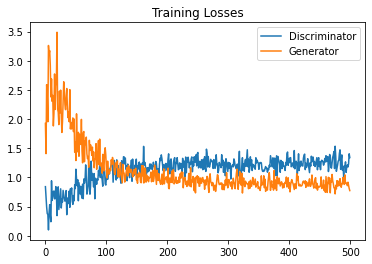

In [10]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

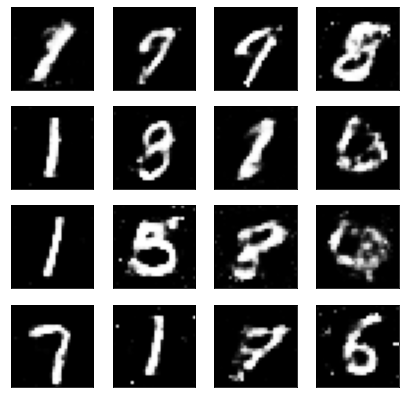

In [11]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

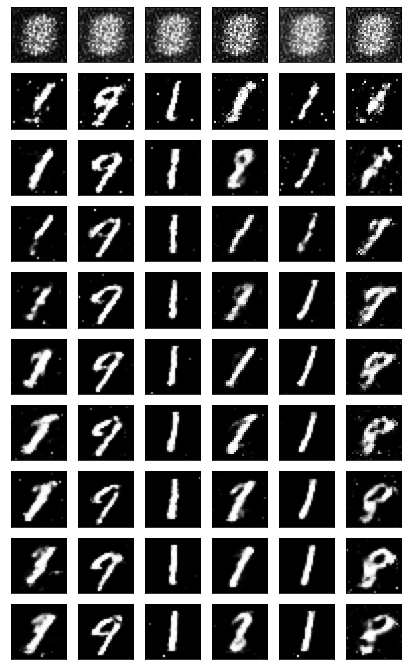

In [12]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)